# Telematics Data forecasting with ARIMA model

In this notebook, we are trying to build up a Time Series Model to forecast the Telematics data ingestion. By visualization and comparing the observed real data curve & forecast curve, it is intuitive to identify the new coming data is in normal/abnormal pattern. 

In [9]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
import statsmodels.api as sm
from datetime import datetime, timedelta
from matplotlib.ticker import FuncFormatter

# Defaults
plt.rcParams['figure.figsize'] = (20, 8)
plt.style.use('ggplot')

## Step 1 - Data preparation and visualization

As mentioned in `README.md`, the dataset we are using is collected from huge number of real cars, but it is not the Raw Telematics data, it has been aggregated in every hour. 

In [10]:
# Can update here if acquire data from other data sources 


In [11]:
df = pd.read_csv('../data/telematics_data.csv')

In [12]:
df.head()

,dd,day_hour,num_records,num_sessions,num_vins
0,2017-12-28,5,36851,569,535
1,2017-12-28,6,80184,872,750
2,2017-12-28,7,36796,391,374
3,2017-12-28,9,1450,85,85
4,2017-12-28,10,20005,549,518


In [13]:
df.shape

(5239, 5)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5239 entries, 0 to 5238
Data columns (total 5 columns):
dd              5239 non-null object
day_hour        5239 non-null int64
num_records     5239 non-null int64
num_sessions    5239 non-null int64
num_vins        5239 non-null int64
dtypes: int64(4), object(1)
memory usage: 204.7+ KB


In [15]:
# Convert to type datetime
df['dt'] = df.apply(lambda r: pd.to_datetime('{} {}:00:00'.format(r['dd'], r['day_hour'])), axis=1)
print(df['dt'].max())

2018-08-20 23:00:00


In [16]:
df.head()

,dd,day_hour,num_records,num_sessions,num_vins,dt
0,2017-12-28,5,36851,569,535,2017-12-28 05:00:00
1,2017-12-28,6,80184,872,750,2017-12-28 06:00:00
2,2017-12-28,7,36796,391,374,2017-12-28 07:00:00
3,2017-12-28,9,1450,85,85,2017-12-28 09:00:00
4,2017-12-28,10,20005,549,518,2017-12-28 10:00:00


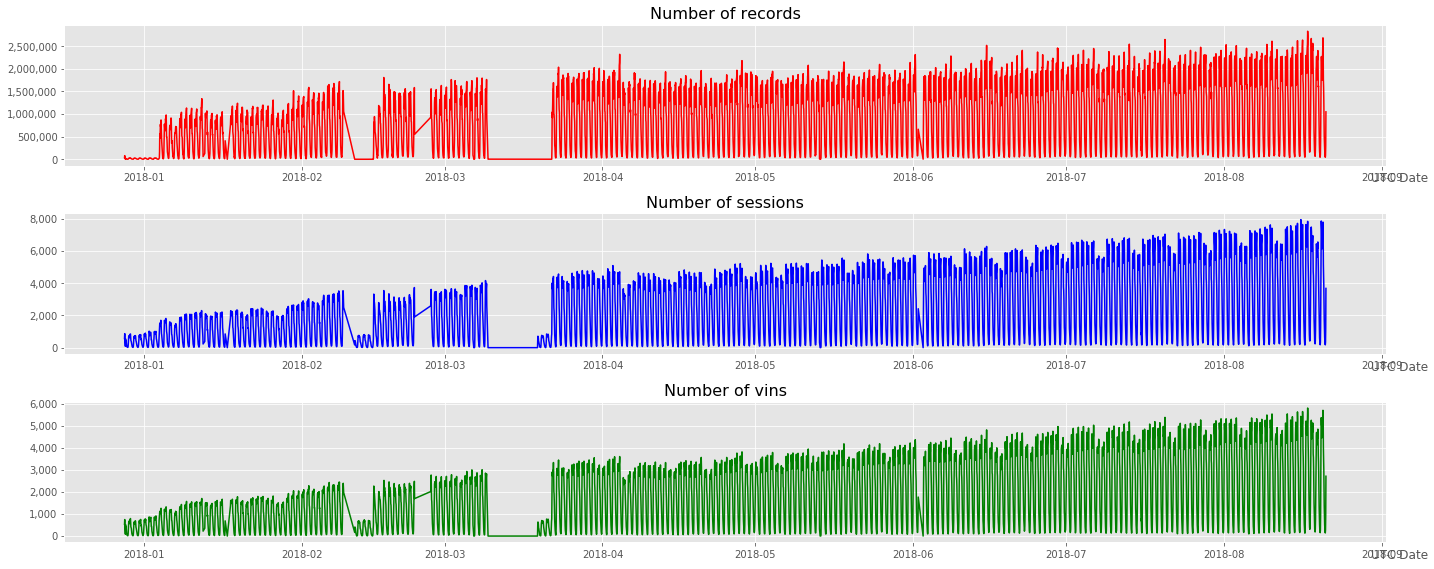

In [17]:
# Plot and save images
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(311)
ax1.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.set_title('Number of records', fontsize=16)
ax1.xaxis.set_label_coords(1.01, -0.045)
plt.xlabel('UTC Date')
plt.plot(df.dt, df.num_records, 'r-')
ax2 = fig.add_subplot(312)
ax2.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
ax2.set_title('Number of sessions', fontsize=16)
ax2.xaxis.set_label_coords(1.01, -0.045)
plt.xlabel('UTC Date')
plt.plot(df.dt, df.num_sessions, 'b-')
ax3 = fig.add_subplot(313)
ax3.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
ax3.set_title('Number of vins', fontsize=16)
ax3.xaxis.set_label_coords(1.01, -0.045)
plt.xlabel('UTC Date')
plt.plot(df.dt, df.num_vins, 'g-')
plt.tight_layout()

img = '../image/{}.png'.format(datetime.today().strftime('%Y-%m-%d'))
fig.savefig(img)

The data before 2018 Q1 looks not stable/continuous, so I decide to drop it for further analysis.

In [20]:
df = df[df['dt'] > '2018-04-01'] 
df.shape

(3382, 6)

### Short conclusion: 

* The aggregated Telematics data has an obvious seasonality pattern, with an overall slight increasing trend (We will also plot a more clear figure in Step 3 by decomposing our time series into three distinct components: trend, seasonality, and noise).
* The data before 2018 Q1 looks not stable/continuous, so I decide to drop it for further analysis.
* We can also build up our model using the data of `one month/two weeks/one week` and compare the final result. 


## Step 2 - Handling Time Series

In [21]:
# Only keep the columns we are going to use
df = df[['dt', 'num_records', 'num_sessions', 'num_vins']]
print(df.head())
print(df.dtypes)

                      dt  num_records  num_sessions  num_vins
1857 2018-04-01 01:00:00      1612661          4259      2932
1858 2018-04-01 02:00:00      1716344          4452      3073
1859 2018-04-01 03:00:00      1625034          4194      3037
1860 2018-04-01 04:00:00      1395103          3678      2773
1861 2018-04-01 05:00:00      1608405          3868      2950
dt              datetime64[ns]
num_records              int64
num_sessions             int64
num_vins                 int64
dtype: object


In [22]:
# Set Index 
df = df.set_index('dt')
print(df.head())
print(df.index)

                     num_records  num_sessions  num_vins
dt                                                      
2018-04-01 01:00:00      1612661          4259      2932
2018-04-01 02:00:00      1716344          4452      3073
2018-04-01 03:00:00      1625034          4194      3037
2018-04-01 04:00:00      1395103          3678      2773
2018-04-01 05:00:00      1608405          3868      2950
DatetimeIndex(['2018-04-01 01:00:00', '2018-04-01 02:00:00',
               '2018-04-01 03:00:00', '2018-04-01 04:00:00',
               '2018-04-01 05:00:00', '2018-04-01 06:00:00',
               '2018-04-01 07:00:00', '2018-04-01 08:00:00',
               '2018-04-01 09:00:00', '2018-04-01 10:00:00',
               ...
               '2018-08-20 14:00:00', '2018-08-20 15:00:00',
               '2018-08-20 16:00:00', '2018-08-20 17:00:00',
               '2018-08-20 18:00:00', '2018-08-20 19:00:00',
               '2018-08-20 20:00:00', '2018-08-20 21:00:00',
               '2018-08-20 22:00:

In [23]:
# Convert the columns into a Series object to prevent referring to columns names every time
ts_r = df['num_records']
ts_s = df['num_sessions']
ts_v = df['num_vins']

Convert TS to specified frequency. 'D' is default, in our case the frequency should be hour.  
All offset aliases can be found here: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html

In [24]:
ts_r = ts_r.asfreq('H', method='pad')
ts_s = ts_s.asfreq('H', method='pad')
ts_v = ts_v.asfreq('H', method='pad')
ts_r.head()

dt
2018-04-01 01:00:00    1612661
2018-04-01 02:00:00    1716344
2018-04-01 03:00:00    1625034
2018-04-01 04:00:00    1395103
2018-04-01 05:00:00    1608405
Freq: H, Name: num_records, dtype: int64

## Step 3 - Check Stationarity of Time Series

Most of the TS models work on the assumption that the TS is stationary.
What does "stationary" mean? we can assume the series to be stationary if it has constant statistical properties over time, ie. the following: 
* Constant mean
* Constant variance
* An autocovariance that does not depend on time

To check stationarity, first and foremost way is to simple plot the data and analyze visually: 

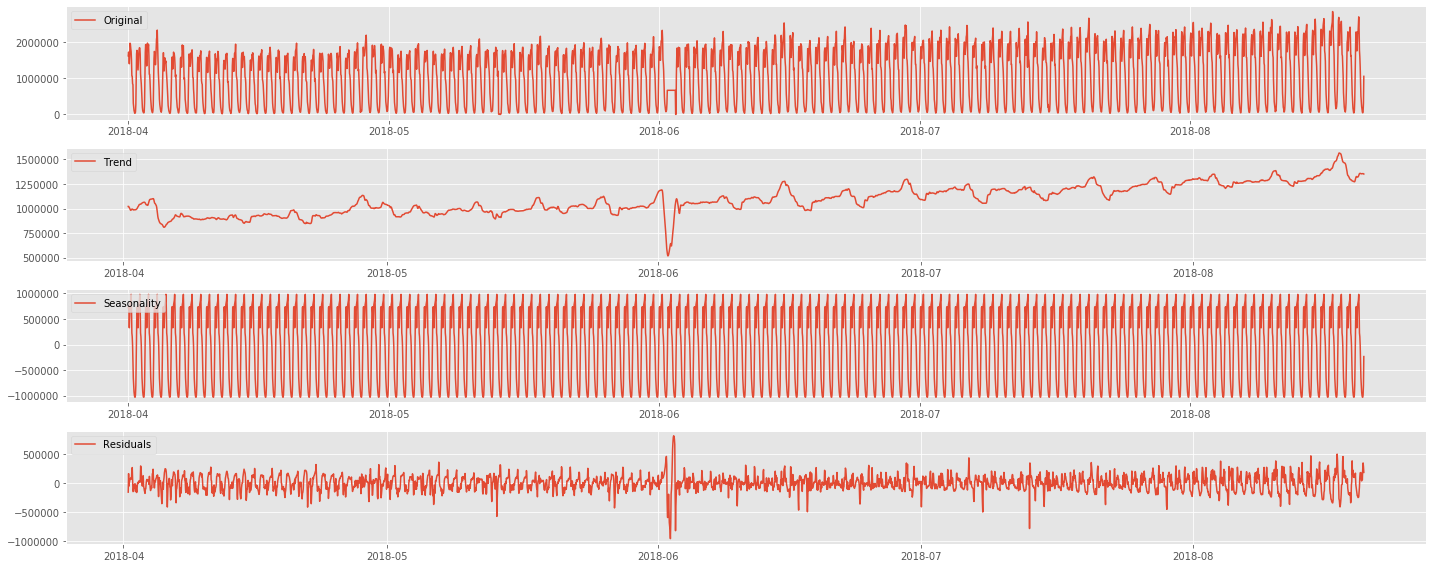

In [25]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_r)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(20,8))
plt.subplot(411)
plt.plot(ts_r, label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='upper left')
plt.tight_layout()

More formally, we can check stationarity by:  
* Plotting Rolling Statistics:   
We can plot the moving average or moving variance and see if it varies with time. 
* Dickey-Fuller Test:   
This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the TS is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. 

In [26]:
# Define function using the rolling statistics plots along with Dickey-Fuller test results
# In our case let's set the time window as one weeks (168 hours)
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=168,center=False).mean()
    rolstd =timeseries.rolling(window=168,center=False).std()

    #Plot rolling statistics:
    plt.figure(figsize=(16,4))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

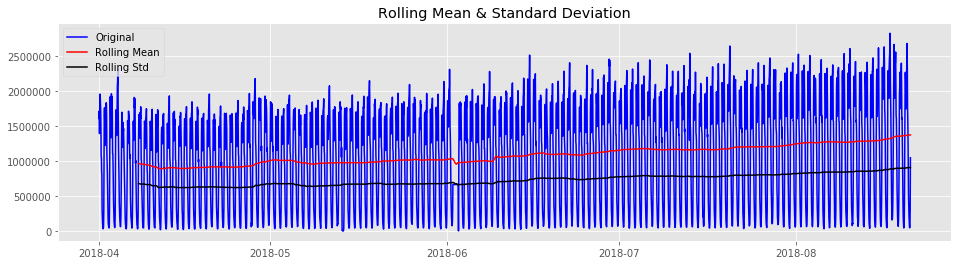

Results of Dickey-Fuller Test:
Test Statistic                   -3.800091
p-value                           0.002906
#Lags Used                       29.000000
Number of Observations Used    3377.000000
Critical Value (1%)              -3.432288
Critical Value (5%)              -2.862396
Critical Value (10%)             -2.567226
dtype: float64


In [27]:
test_stationarity(ts_r)

From the visualization we can see the variation is small and the line looks very smooth, the mean is quite smooth as well.     
It turns out our judgement is correct by the DF-test result, because the test statistic is smaller than the critical values (Note that the signed values should be compared and not the absolute values).

### Short conclusion: 
From statistic perspective, the Telelog data can be regarded as "Stationary", so we will not do addtional improvements on the data. 

## Step 4 - ARIMA Time Series Model
How to choose forecasting models? please refer: https://people.duke.edu/~rnau/411fcst.htm  
In this case we are going to use ARIMA as our forecasting model, more details for ARIMA please refer: https://people.duke.edu/~rnau/411arim.htm  



## Step 5 - Parameter Selection for the ARIMA Time Series Model

We will use a "grid search" to iteratively explore different combinations of parameters. For each combination of parameters, we fit a new seasonal ARIMA model with the SARIMAX() function from the statsmodels module and assess its overall quality. Once we have explored the entire landscape of parameters, our optimal set of parameters will be the one that yields the best performance for our criteria of interest.  
This idea is inspired by https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3

In [28]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 24) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 24)
SARIMAX: (0, 0, 1) x (0, 1, 0, 24)
SARIMAX: (0, 1, 0) x (0, 1, 1, 24)
SARIMAX: (0, 1, 0) x (1, 0, 0, 24)


We will use the AIC (Akaike Information Criterion) value, which is conveniently returned with ARIMA models fitted using statsmodels. The AIC measures how well a model fits the data while taking into account the overall complexity of the model. We are interested in finding the model that yields the lowest AIC value.

In [29]:
import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages

AIC = []
SARIMAX = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(ts_r,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()

            print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))           
            AIC.append(results.aic)
            SARIMAX.append([param, param_seasonal])           
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 24) - AIC:105688.5914197034
ARIMA(0, 0, 0)x(0, 0, 1, 24) - AIC:102621.95601169587
ARIMA(0, 0, 0)x(0, 1, 0, 24) - AIC:91221.97895693882
ARIMA(0, 0, 0)x(0, 1, 1, 24) - AIC:89684.60225328135
ARIMA(0, 0, 0)x(1, 0, 0, 24) - AIC:91242.70736368411
ARIMA(0, 0, 0)x(1, 0, 1, 24) - AIC:90594.6332456124
ARIMA(0, 0, 0)x(1, 1, 0, 24) - AIC:90053.30328808224
ARIMA(0, 0, 0)x(1, 1, 1, 24) - AIC:89655.79819636453
ARIMA(0, 0, 1)x(0, 0, 0, 24) - AIC:103014.79585672126
ARIMA(0, 0, 1)x(0, 0, 1, 24) - AIC:101645.89995191194
ARIMA(0, 0, 1)x(0, 1, 0, 24) - AIC:89549.76751071065
ARIMA(0, 0, 1)x(0, 1, 1, 24) - AIC:88145.25550912257
ARIMA(0, 0, 1)x(1, 0, 0, 24) - AIC:101351.16971163184
ARIMA(0, 0, 1)x(1, 0, 1, 24) - AIC:101284.9015620708
ARIMA(0, 0, 1)x(1, 1, 0, 24) - AIC:88486.2340259637
ARIMA(0, 0, 1)x(1, 1, 1, 24) - AIC:88146.74107666529
ARIMA(0, 1, 0)x(0, 0, 0, 24) - AIC:95161.14087005804
ARIMA(0, 1, 0)x(0, 0, 1, 24) - AIC:92738.58351918458
ARIMA(0, 1, 0)x(0, 1, 0, 24) - AIC:89184.518

The params with lowest AIC value will be used for training our model in next steps

In [30]:
print('The lowest AIC is {} for model SARIMAX{}x{}'.format(min(AIC), 
                                                             SARIMAX[AIC.index(min(AIC))][0],
                                                             SARIMAX[AIC.index(min(AIC))][1]))

The lowest AIC is 86996.7252247945 for model SARIMAX(1, 0, 1)x(1, 1, 1, 24)


## Step 6 - Fitting an ARIMA Time Series Model
More optional params please refer http://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html 

In [31]:
mod = sm.tsa.statespace.SARIMAX(ts_r,
                                order=SARIMAX[AIC.index(min(AIC))][0],
                                seasonal_order=SARIMAX[AIC.index(min(AIC))][1],
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7484      0.011     65.822      0.000       0.726       0.771
ma.L1          0.0431      0.016      2.684      0.007       0.012       0.074
ar.S.L24       0.0651      0.020      3.208      0.001       0.025       0.105
ma.S.L24      -0.7416      0.010    -72.780      0.000      -0.762      -0.722
sigma2       1.44e+10   2.25e-13   6.41e+22      0.000    1.44e+10    1.44e+10


The coef column shows the weight (i.e. importance) of each feature and how each one impacts the time series.   
The P>|z| column informs us of the significance of each feature weight. 

When fitting seasonal ARIMA models, it is important to run model diagnostics to ensure that none of the assumptions made by the model have been violated. The plot_diagnostics object allows us to quickly generate model diagnostics and investigate for any unusual behavior.

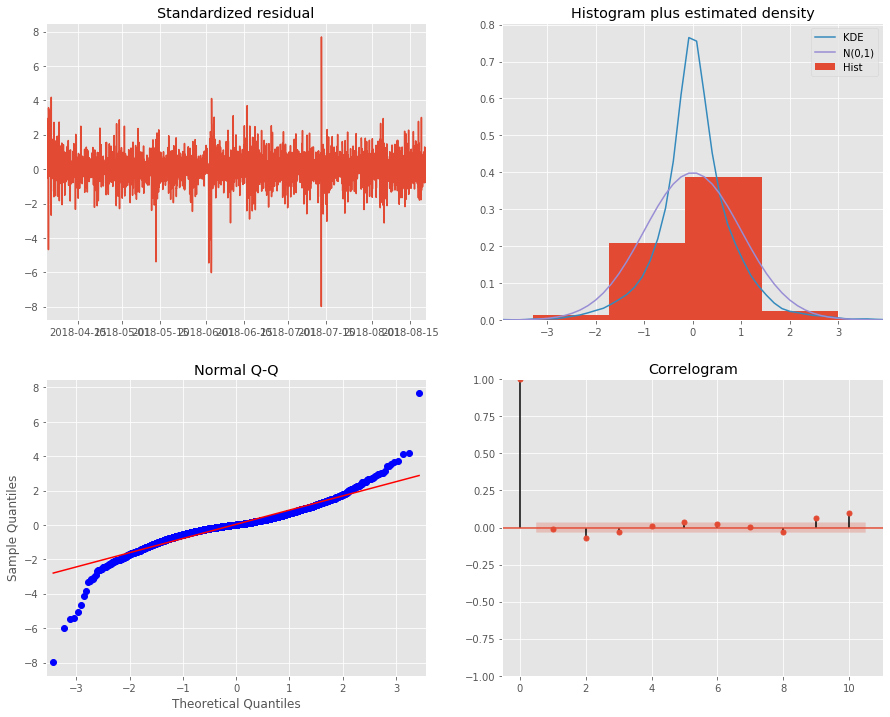

In [32]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In the plots we can see that the residuals are basically not uncorrelated (bottom right plot). Also, the residuals and roughly normally distributed with zero mean (top right plot). The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) roghly follows the linear trend of samples taken from a standard normal distribution with N(0, 1). Basically the residuals can be regarded as normally distributed.

## Step 7 - Validating Forecasts

In [33]:
# Obtain the values and associated confidence intervals for forecasts of the time series.
pred = results.get_prediction(start=pd.to_datetime('2018-08-13 01:00:00'), dynamic=False)
pred_ci = pred.conf_int()

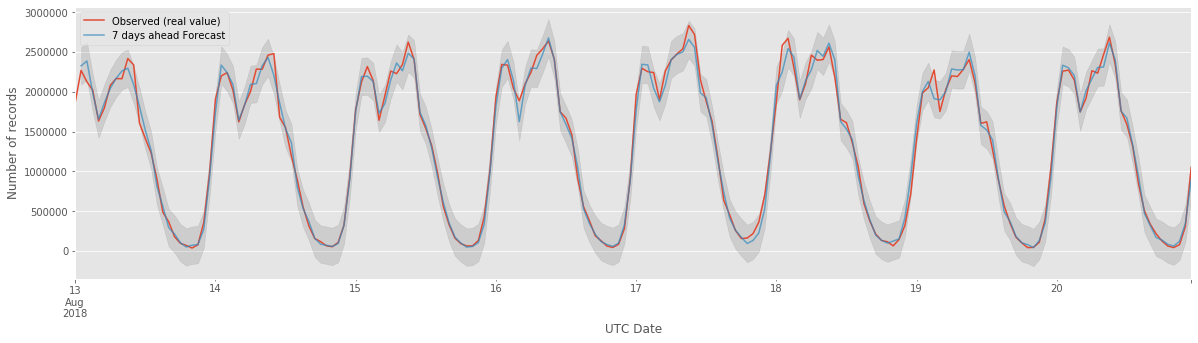

In [35]:
plt.figure(figsize=(20,5))
ax = ts_r['2018-08-13':].plot(label='Observed (real value)')
pred.predicted_mean.plot(ax=ax, label='7 days ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.1)

ax.set_xlabel('UTC Date')
ax.set_ylabel('Number of records')
plt.legend()
plt.show()

### Quantifing the accuracy
The forecast looks good, but we still need to quantify the accuracy of our forecasts. The benifits are: 
* As a single value Metric to fine tuning our model 
* Will be a reference for labeling our email notification level (INFO, WARNING, or ERROR) 

We will first use MSE (Mean Squared Error):

In [36]:
y_forecasted = pred.predicted_mean
y_truth = ts_r['2018-08-13 01:00:00':] # predict last few days only for demostration

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The MSE of our forecasts is {}'.format(round(mse)))

The MSE of our forecasts is 9537953756


MSE is an absolute metric, therefore scale-dependent. Considering the absolute value of MSE is pretty big, it would be better to introduce a commonly-used percentage error measure: Mean Absolute Percentage Error (MAPE)

In [37]:
# Compute the Mean Absolute Percentage Error
mape = np.mean(np.abs((y_truth - y_forecasted) / y_truth)) * 100
print('The MAPE of our forecasts is {:.2f}%'.format(mape))

The MAPE of our forecasts is 9.49%


### Re-plot with forecasts

## Step 8 - Fine tuning the model
We will fine tuning our model based on a series of questions

### Quetion 1: How long do we need the data to train our model?
A: Now let's use the same approach to re-train the model based on the data of two week/one week, and finally decide which is suitable.  
I have tested it in separated notebooks (arima_1m.ipynb, arima_2w.ipynb, arima_1w.ipynb) and compared the results, finally I decided to use last One Month data to train the model.

### Question 2: The forecast for Number of session, and Number of vins? 
A: we will do that in separated notebooks as well (`arima_session.ipynb, arima_vin.ipynb`)   
The performance is quite similar to the forecast of Number of records, the major difference is the parameter combination: 
* Number of records: ARIMA(1, 1, 1)x(0, 1, 1, 24)   
* Number of sessions: ARIMA(1, 0, 1)x(1, 1, 1, 24)   
* Number of vins: ARIMA(1, 1, 1)x(0, 1, 1, 24)   